## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Step 1 : Calibrate the camera using chessboard images

In [1]:
import glob
import pickle

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

import image_utils
from IPython.display import HTML
%matplotlib inline

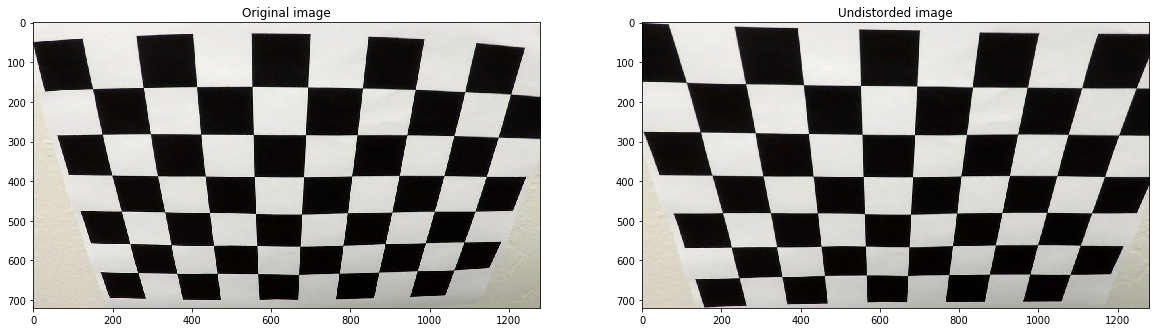

In [2]:
# Get all calibration images at our disposal:
calibration_images = glob.glob('camera_cal/calibration*.jpg')
    
# Using the code from the lesson :
# We first create a list of object points and image points that
# will enable us to use the opencv calibrate function
objpoints = []
imgpoints = []
    
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates
    
# Then, for each image in the calibration folder with get
# the object points
for image in calibration_images:
    img = mpimg.imread(image)
    # Grayscale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        
# Calibrate the camera from our imagepoints and object points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# We save the calibration for later use
calibration_pkl = {}
calibration_pkl["mtx"] = mtx
calibration_pkl["dist"] = dist
pickle.dump(calibration_pkl, open('./calibration.p', "wb" ) )

# Now, let's test our calibration on a calibration image and save it
raw_img = mpimg.imread('./camera_cal/calibration2.jpg')
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)

figure, ax = plt.subplots(1,2 , figsize=(20,10))
ax[0].imshow(raw_img)
ax[0].set_title('Original image')
ax[1].imshow(dst)
ax[1].set_title('Undistorded image')

# We can see this image in the P2_writeup.md
figure.savefig('./output_images/undistorded_chessboard.jpg', transparent=True, bbox_inches = 'tight')

## Step 2 : Test calibration on test images

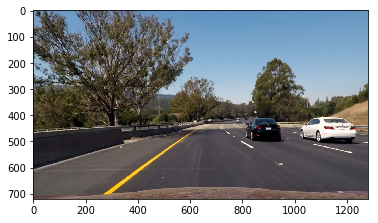

In [3]:
# Now let us try on the /test_images folder:
test_images = sorted(glob.glob('./test_images/test*.jpg'))
for idx, image in enumerate(test_images):
    raw_img = mpimg.imread(image)
    dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
    plt.imshow(dst)
    # Save test images, add +1 to index to match the test* image number
    mpimg.imsave('./output_images/undistorded%d.png'%(idx+1), dst)

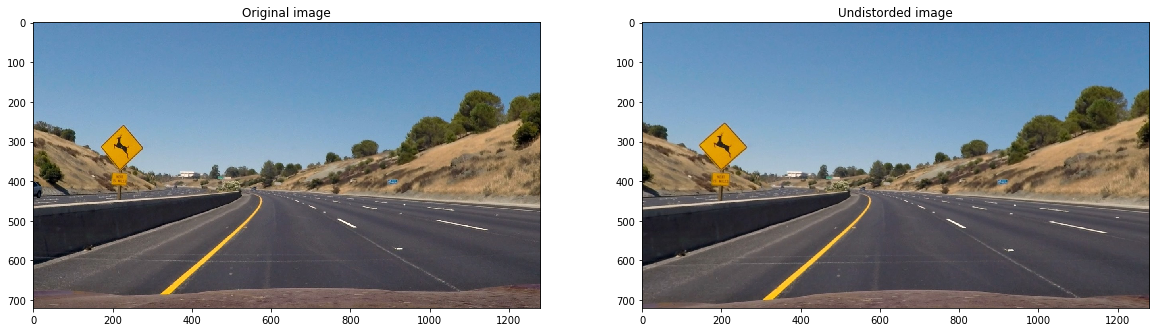

In [4]:
#OPTIONAL : Create a figure for the write up
raw_img = mpimg.imread('./test_images/test2.jpg')
dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
figure, ax = plt.subplots(1,2 , figsize=(20,10))
ax[0].imshow(raw_img)
ax[0].set_title('Original image')
ax[1].imshow(dst)
ax[1].set_title('Undistorded image')

# We can see this image in the P2_writeup.md
figure.savefig('./output_images/undistorded_example.jpg', transparent=True, bbox_inches = 'tight')

# See how the traffic sign looks slightly more flattened as a result of undistorsion

# Step 3 : Create a thresholded image 

See the code in the image_utils.py module for more information.
The `generate_binarized()` function implements the following pipeline:
- Apply a hard thresholding on the **Sobel operator**
- Apply a gradient magnitude thresholding
  - Both previous thresholding are enought to get a robust identification of image areas with a strong change in color. Note that we are looking for light colored (most of the time white or yellow) on a dark background : asphalt, concrete... Hence, the gradient around the lines is supposed to be strong.
- Apply gradient direction thresholding, although I believe this step is not as insightful than the previous two. We can set it to `False` in my function.
- Transform image in the HLS color space and apply S channel thresholding

In [5]:
image = mpimg.imread('./test_images/straight_lines2.jpg')
contribs, output = image_utils.generate_binarized(image, 
                                     absolute = True, abs_thresh = (50,200),
                                     magnitude = True, mag_thresh = (50,255),
                                     direction = True, dir_thresh = (0.8,1.3),
                                     color_thresh = (150,255))

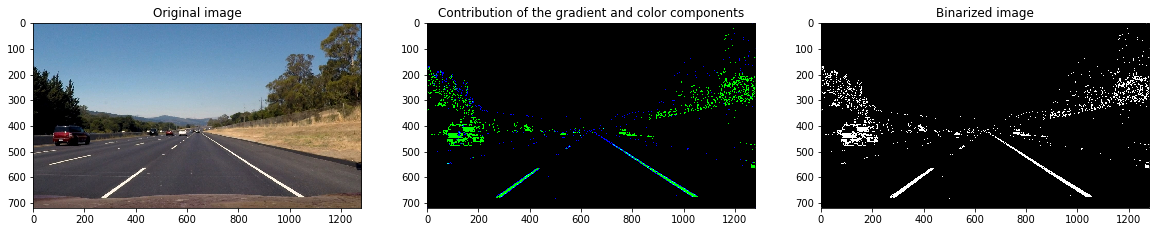

In [6]:
#OPTIONAL : Create a figure for the write up
figure, ax = plt.subplots(1,3 , figsize=(20,10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(contribs)
ax[1].set_title('Contribution of the gradient and color components')
ax[2].imshow(output, cmap= 'gray')
ax[2].set_title('Binarized image')

# We can see this image in the P2_writeup.md
figure.savefig('./output_images/contribs.jpg', transparent=True, bbox_inches = 'tight')
# See how the traffic sign looks slightly more flattened as a result of undistorsion

# Step 4 : Apply perspective transform

The goal here is to warp the image to be able to locate accurately the lane in front of the vehicle. To do that, let us begin by identifying the `source` and `destination` points that will enable us to find the transformation matrix and compute the warped image.

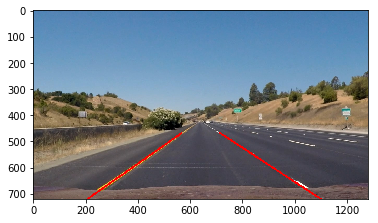

In [7]:
# Identify source points
BOTTOM_LEFT = [0.162*image.shape[1], image.shape[0]]
TOP_LEFT = [0.444*image.shape[1], 0.65*image.shape[0]]
BOTTOM_RIGHT = [0.86*image.shape[1], image.shape[0]]
TOP_RIGHT = [0.558*image.shape[1],0.65*image.shape[0]]

image = mpimg.imread('./test_images/straight_lines1.jpg')
laned = cv2.line(image, tuple([int(i) for i in BOTTOM_LEFT]), tuple([int(i) for i in TOP_LEFT]), color = (255,0,0), thickness=5)
laned = cv2.line(laned, tuple([int(i) for i in BOTTOM_RIGHT]), tuple([int(i) for i in TOP_RIGHT]), color = (255,0,0), thickness=5)

plt.imshow(laned)

It seems that we can use the following `source` points to perform our perspective transform : 

In [8]:
print('Bottom left :', BOTTOM_LEFT)
print('Top left :', TOP_LEFT)
print('Bottom right :', BOTTOM_RIGHT)
print('Top right :', TOP_RIGHT)

Bottom left : [207.36, 720]
Top left : [568.32, 468.0]
Bottom right : [1100.8, 720]
Top right : [714.24, 468.0]


Now that we identified our `source` points, we need to find our `destination` points. We know that our two lanes are roughly parallel and that our origin absciss is `207.36` for the left lane, and `1100.8` . So we could imagine keep the bottom coordinates and trying the following top coordinates: [207.36, 0] and [1100.8, 0].    

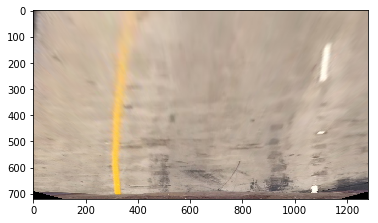

In [9]:
image = mpimg.imread('./test_images/test1.jpg')
src = np.float32([BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT, TOP_LEFT])
dst = np.float32([[image.shape[0]*.4, image.shape[0]], 
                  [image.shape[1]*0.8, image.shape[0]],
                  [image.shape[1]*0.8, 0], 
                  [image.shape[0]*.4, 0]])
warped_img, _, _ = image_utils.warper(image, src, dst)
plt.imshow(warped_img) # Show results

The previous points we chosed seem to do the job correctly.

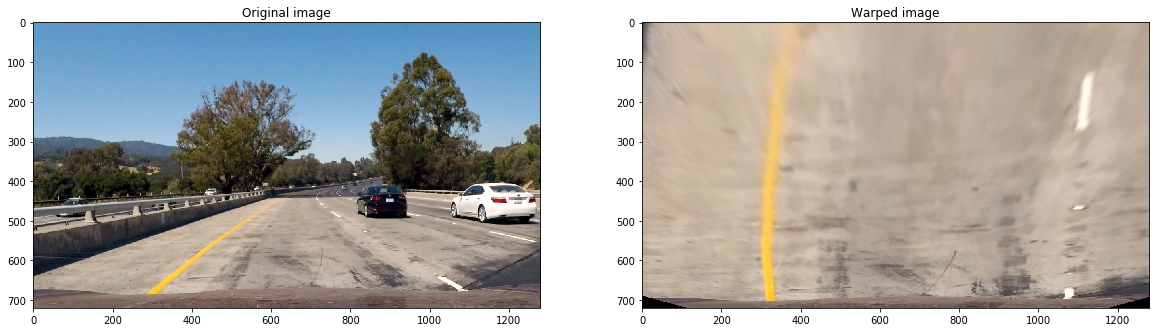

In [10]:
#OPTIONAL FOR WRITEUP
figure, ax = plt.subplots(1,2 , figsize=(20,10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(warped_img)
ax[1].set_title('Warped image')

# We can see this image in the P2_writeup.md
figure.savefig('./output_images/warping.jpg', transparent=True, bbox_inches = 'tight')
# See how the traffic sign looks slightly more flattened as a result of undistorsion

Now, let us try on the binarized image:

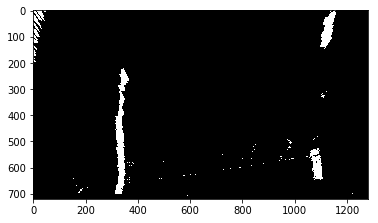

In [11]:
image = mpimg.imread('./test_images/thumb1.jpg')
_, output = image_utils.generate_binarized(image, 
                                     absolute = True, abs_thresh = (40,200),
                                     magnitude = True, mag_thresh = (40,255),
                                     direction = True, dir_thresh = (0.7,1.3),
                                     color_thresh = (180,255))

warped_img, _, _ = image_utils.warper(output, src, dst)
plt.imshow(warped_img, cmap = 'gray') # Show results

# Step 5 : Find lane boundaries

Now that we have generated a binarized warped image, we need to find the lanes. Let us do the histogram peaks method

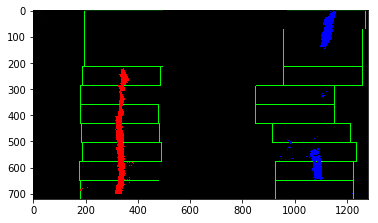

In [12]:
out_img, _, _, _, left_coeffs, right_coeffs = image_utils.fit_polynomial(warped_img)
plt.imshow(out_img)

# Step 6 : Determine curvature

In [13]:
leftx, left_fit, rightx, right_fit = image_utils.search_around_poly(warped_img, left_coeffs, right_coeffs)

In [15]:
image_utils.measure_curvature(left_coeffs, right_coeffs)

(4757.954694191351, 1282.367941698414, 0.5595316441496768)

# Step 7 : Display detected lanes back to original image

Now that we have detected the lanes and fitted them with a polynomial.

In [16]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients of the last n fit of the line
        self.recent_fit = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    #Once we have fitted a line, make sure we update all the parameters when reading in a new frame
    def update(self, poly_coeffs, x_values, n=10):
        #If a polynomial was fitted
        if poly_coeffs is not None:
            # Make sure that the detected is pass to True
            self.detected = True
            # Update current fit
            self.current_fit = poly_coeffs
            # Check that current fit is in par with best fit:
            if self.best_fit is not None:
                # if we have already have a best fit, see how this new fit compares
                self.diffs = abs(self.current_fit-self.best_fit)
                
                # If the variation is small, it is likely to be consistent hence, we add it to the best fit

                if self.diffs[0] < 0.001 and self.diffs[1] < 1 and self.diffs[2] < 1000:
                    self.recent_fit.append(self.current_fit)
                    if len(self.recent_fit) > n:
                        self.recent_fit.pop(0)                    
                        self.recent_xfitted.pop(0)
                    self.best_fit = np.average(self.recent_fit, axis = 0)
                    self.allx = x_values
                    self.ally = self.current_fit[0]*self.allx**2 + self.current_fit[1]*self.allx + self.current_fit[2]
                    self.recent_xfitted.append(self.allx)
                    self.bestx = np.average(self.recent_xfitted, axis=0)
            else:
                self.best_fit = self.current_fit
                self.recent_fit.append(self.current_fit)
                self.best_fit = np.average(self.recent_fit, axis = 0)
                self.allx = x_values
                self.ally = self.current_fit[0]*self.allx**2 + self.current_fit[1]*self.allx + self.current_fit[2]
                self.recent_xfitted.append(self.allx)
                self.bestx = np.average(self.recent_xfitted, axis=0)
 
        else:
            self.detected = False

# Step 8 : Sanity checks

In [18]:
def correct_distance(left_lane, right_lane):
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    average = np.mean(right_lane.ally - left_lane.ally)
    #Theoretically, the lane is around 800 px wide with our parametrization
    # So, we allow a margin of 30% (which is large !)
    if 800*0.7 < average < 800*1.3:
        return True
    else :
        return False

In [19]:
def parallel(left_lane, right_lane):
    diffs = left_lane.best_fit - right_lane.best_fit
    if diffs[0] < 0.001 and diffs[1] < 1 and diffs[2] < 1000:
        return True
    else :
        return False

In [20]:
def check_similar_curvature(left_lane, right_lane):
    if abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature) < 2000:
        return True
    else:
        return False

# Step 9 : Define pipeline

In [17]:
# Identify source points
BOTTOM_LEFT = [0.162*image.shape[1], image.shape[0]]
TOP_LEFT = [0.444*image.shape[1], 0.65*image.shape[0]]
BOTTOM_RIGHT = [0.86*image.shape[1], image.shape[0]]
TOP_RIGHT = [0.558*image.shape[1],0.65*image.shape[0]]

SRC = np.float32([BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT, TOP_LEFT])
DST = np.float32([[image.shape[0]*.4, image.shape[0]], 
                  [image.shape[1]*0.8, image.shape[0]],
                  [image.shape[1]*0.8, 0], 
                  [image.shape[0]*.4, 0]])

In [28]:
left_lane = Line()
right_lane = Line()

def process_image(img):
    _, binarized = image_utils.generate_binarized(img, abs_thresh = (50,200) ,
                                                 mag_thresh= (50,255),
                                                 dir_thresh= (0.7,1.3),
                                                 color_thresh = (150,255))
    warped_img, M, Minv = image_utils.warper(binarized, SRC, DST)
    
    
    # If one of the lane was not detected on the last frame, then use fit polynomial
    if not left_lane.detected or not right_lane.detected:
        _, left_fitx, right_fitx, ploty, left_fit, right_fit = image_utils.fit_polynomial(warped_img)

    # Otherwise, use the search_around_poly method
    else:
        left_fitx, left_fit, right_fitx, right_fit = image_utils.search_around_poly(warped_img, left_lane.best_fit, right_lane.best_fit)
    

    left_lane.update(left_fit, left_fitx)
    right_lane.update(right_fit, right_fitx)
    
    # draw the current best fit if it exists
    if left_lane.best_fit is not None and right_lane.best_fit is not None:
        left_lane.radius_of_curvature, right_lane.radius_of_curvature, d_center = measure_curvature(left_lane.best_fit, right_lane.best_fit)
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Implement sanity checks :
        dist = correct_distance(left_lane, right_lane)
        paral = parallel(left_lane, right_lane)
        sim_curv = check_similar_curvature(left_lane, right_lane)

        cdts_to_check = (dist,paral, sim_curv)
        cdts_checked = sum(1 for cdt in cdts_to_check if cdt)
        
        if cdts_checked >=1:
            # If one out of three checks are passed, then plot back the line:
            # In practice, on more complicated example, such as the challenges, we should handle such cases
            # much more carefully
            output = image_utils.lane_back_to_image(img, warped_img, left_lane.bestx, right_lane.bestx, 
                                                    ploty, Minv, left_lane.radius_of_curvature, right_lane.radius_of_curvature, d_center)
        else:
            output = img
    else:
        output = img
    return output

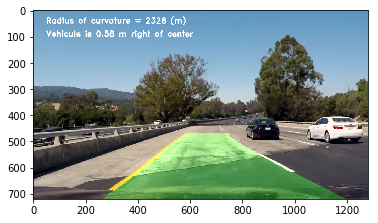

In [29]:
output = process_image(image)
plt.imshow(output)

# Step 9 :  Output

In [30]:
output_path = 'output_videos/output_project.mp4'
clip = VideoFileClip('project_video.mp4')
output_video = clip.fl_image(process_image)

%time output_video.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video output_videos/output_project.mp4
[MoviePy] Writing video output_videos/output_project.mp4


100%|█████████▉| 1260/1261 [04:04<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project.mp4 

CPU times: user 4min 10s, sys: 52.7 s, total: 5min 3s
Wall time: 4min 5s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [24]:
output_path = 'output_videos/challenge_video.mp4'
clip = VideoFileClip('challenge_video.mp4')
output_video = clip.fl_image(process_image)

%time output_video.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [01:34<00:00,  5.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 35s, sys: 20.5 s, total: 1min 56s
Wall time: 1min 34s


In [50]:
def process_image(img):
    _, binarized = image_utils.generate_binarized(img)
    warped_img, M, Minv = image_utils.warper(binarized, SRC, DST)
    leftcoeffs, rightcoeffs, leftfitx, rightfitx, ploty = image_utils.search_around_poly(warped_img)
    left_lane.update(left_coeffs, leftfitx)
    right_lane.update(right_coeffs, rightfitx)
    output = image_utils.lane_back_to_image(img, warped_img, left_lane.best_fit, right_lane.best_fit, ploty, Minv)
    return output

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)